# Tongue Segmentation using U2NET


## Import Libraries

In [27]:
import torch
import os
import cv2
import numpy as np
from model.u2net import U2NET
import matplotlib.pyplot as plt
from ollama import chat
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

## Configuration

In [28]:
# Configuration
img = cv2.imread('BT1_jpg.rf.c5126a62fd408a668277c376dbbb3bfb.jpg')         # Input images
PRED_MASK_DIR = 'output/validated_pred_masks'    # Output predicted masks
OVERLAY_DIR = 'output/vali_overlays'              # Output overlay images
tongue_extraction_dir = 'output/tongue_extraction'        # Output extracted tongue images
MODEL_PATH = 'checkpoints/u2net_finetuned_with2600_data_more.pth'   # Trained model weights

## Create Output Directories

In [29]:
# Create output directories
os.makedirs(PRED_MASK_DIR, exist_ok=True)
os.makedirs(OVERLAY_DIR, exist_ok=True)
os.makedirs(tongue_extraction_dir, exist_ok=True)

## Load Model

In [30]:
# Load model u2net
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = U2NET().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

Using device: cuda


U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

## Functions

In [31]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (320, 320))
    img = img.transpose(2, 0, 1) / 255.0
    return torch.from_numpy(img).unsqueeze(0).float()

def postprocess_mask(pred, original_shape):
    pred = pred[0]
    pred = pred[0, 0].cpu().numpy()
    mask = (pred > 0.5).astype(np.uint8) * 255
    return cv2.resize(mask, (original_shape[1], original_shape[0]))

def create_overlay(image, mask, color=(0, 255, 0), alpha=0.5):
    overlay = image.copy()
    color_mask = np.zeros_like(image)
    color_mask[mask == 255] = color
    return cv2.addWeighted(color_mask, alpha, overlay, 1 - alpha, 0)

def tongue_extraction(image, mask):
    # Create a mask for the tongue area
    tongue_mask = np.zeros_like(mask)
    tongue_mask[mask == 255] = 255
    
    # Extract the tongue region from the image
    extracted_tongue = cv2.bitwise_and(image, image, mask=tongue_mask)
    return extracted_tongue

## Display Results

d:\Hackthon\model\u2net.py:24: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


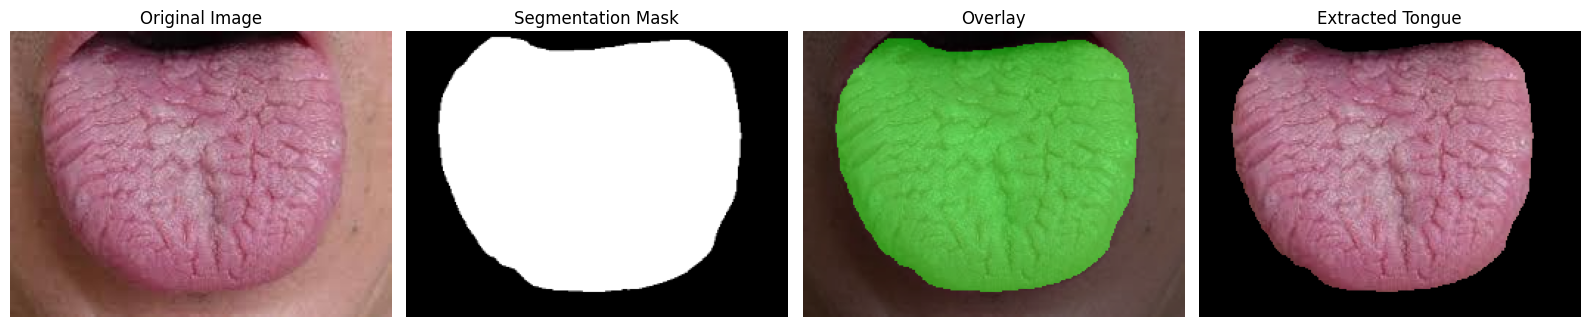

In [32]:
inp = preprocess_image(img).to(device)
    
with torch.no_grad():
    pred = model(inp)
    
mask = postprocess_mask(pred, img.shape)
overlay = create_overlay(img, mask)
tongue = tongue_extraction(img, mask)
    
original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
e_original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
tongue = cv2.cvtColor(tongue, cv2.COLOR_BGR2RGB)

e_tongue = cv2.cvtColor(tongue, cv2.COLOR_BGR2RGB)
    

plt.figure(figsize=(16, 4))
    
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(original)
plt.axis('off')
    
plt.subplot(1, 4, 2)
plt.title('Segmentation Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
    
plt.subplot(1, 4, 3)
plt.title('Overlay')
plt.imshow(overlay)
plt.axis('off')
    
plt.subplot(1, 4, 4)
plt.title('Extracted Tongue')
plt.imshow(tongue)
plt.axis('off')
    
plt.tight_layout()
plt.show()

In [33]:
class_names = ['crenated tongue', 'crenated', 'fissured tongue', 'fissured', 'normal tongue', 'normal']

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model.load_state_dict(torch.load('resnet152_tongue_classifier.pth', map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])   
])


In [36]:
tongue_pil = Image.fromarray(tongue)
input_tensor = preprocess(tongue_pil).unsqueeze(0).to(device)

In [37]:
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_class = predicted.item()


print(f'Predicted class: {class_names[predicted_class]}')

Predicted class: fissured


In [38]:
def normalize_color(image):
    normalized = image.copy().astype(np.float32)
    epsilon = 1e-10
    sum_channels = np.sum(normalized, axis=2) + epsilon

    # Create a 3-channel image where each channel is normalized
    normalized[:,:,0] = normalized[:,:,0] / sum_channels * 255
    normalized[:,:,1] = normalized[:,:,1] / sum_channels * 255
    normalized[:,:,2] = normalized[:,:,2] / sum_channels * 255
    
    return normalized.astype(np.uint8)


In [39]:
def standardize_orientation(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Fit an ellipse to the contour to determine orientation
    if len(largest_contour) < 5:  # Need at least 5 points to fit an ellipse
        return image
    
    ellipse = cv2.fitEllipse(largest_contour)
    center, axes, angle = ellipse
    
    # Create a rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle - 90, 1)  # Rotate to make vertical
    
    # Apply the rotation to the image
    rows, cols = image.shape[:2]
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    
    # Resize to a standard size
    standard_size = (256, 256)
    standardized_image = cv2.resize(rotated_image, standard_size)
    
    return standardized_image

In [40]:
def extract_coating_score(image):
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define range for white/yellowish colors
    lower_white = np.array([0, 0, 180])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)
    
    lower_yellow = np.array([20, 30, 180])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    
    # Combine masks
    coating_mask = white_mask + yellow_mask
    
    # Calculate percentage of coating area
    total_pixels = np.count_nonzero(image[:,:,0] > 0)  # Count non-black pixels
    coating_pixels = np.count_nonzero(coating_mask)
    
    if total_pixels == 0:
        return 0, image
    
    coating_percentage = coating_pixels / total_pixels
    
    # Map percentage to 0-10 scale
    coating_score = min(10, coating_percentage * 30)
    
    # Create visualization for coating
    coating_heatmap = cv2.applyColorMap((coating_mask).astype(np.uint8), cv2.COLORMAP_JET)
    coating_overlay = cv2.addWeighted(image, 0.7, coating_heatmap, 0.3, 0)
    
    return coating_score, coating_overlay

In [41]:
def extract_jagged_shape_score(image, mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0, image
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the perimeter of the contour
    perimeter = cv2.arcLength(largest_contour, True)
    
    # Calculate the area of the contour
    area = cv2.contourArea(largest_contour)
    
    # Calculate circularity (a perfect circle has circularity = 1)
    if perimeter == 0:
        return 0, image
    
    circularity = 4 * np.pi * area / (perimeter ** 2)
    
    # Calculate convex hull
    hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(hull)
    
    # Calculate solidity (ratio of contour area to hull area)
    if hull_area == 0:
        return 0, image
    
    solidity = area / hull_area
    
    # Combine metrics to get jaggedness score
    jaggedness = 10 * (1 - circularity) * (1 - solidity)
    
    # Ensure score is in 0-10 range
    jagged_score = max(0, min(10, jaggedness * 5))
    
    # Create visualization
    vis_image = image.copy()
    cv2.drawContours(vis_image, [largest_contour], -1, (0, 255, 0), 2)
    cv2.drawContours(vis_image, [hull], -1, (0, 0, 255), 2)
    
    return jagged_score, vis_image

In [42]:
def extract_cracks_score(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    
    median_val = np.median(morph)
    lower = int(max(0, 0.66 * median_val))
    upper = int(min(255, 1.33 * median_val))
    edges = cv2.Canny(morph, lower, upper)

    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    crack_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = max(w, h) / (min(w, h) + 1e-5)
        area = cv2.contourArea(contour)
        
        if aspect_ratio > 2 and 10 < area < 3000:
            crack_contours.append(contour)
    
    crack_count = len(crack_contours)
    total_crack_length = sum(cv2.arcLength(contour, False) for contour in crack_contours)
    normalized_crack_length = total_crack_length / (image.shape[0] * image.shape[1])
    crack_score = min(10, crack_count / 4 + normalized_crack_length * 5000)

    crack_image = image.copy()
    cv2.drawContours(crack_image, crack_contours, -1, (0, 0, 255), 2)
    
    return crack_score, crack_image


In [43]:
def extract_filiform_papillae_size_score(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply texture enhancement
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
    
    # Normalize to 0-255 range
    laplacian_norm = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert to uint8
    laplacian_norm = np.uint8(laplacian_norm)
    
    # Apply thresholding to isolate potential papillae
    _, thresh = cv2.threshold(laplacian_norm, 50, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations
    kernel = np.ones((3, 3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours of potential papillae
    contours, _ = cv2.findContours(morph, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by size and shape to identify papillae
    papillae_contours = []
    papillae_sizes = []
    
    for contour in contours:
        area = cv2.contourArea(contour)
        
        # Filiform papillae are typically small, fine structures
        if 5 < area < 100:
            papillae_contours.append(contour)
            papillae_sizes.append(area)
    
    # Calculate score based on average size and count of papillae
    if not papillae_sizes:
        return 0, image
    
    avg_size = np.mean(papillae_sizes)
    normalized_size = min(1.0, avg_size / 50)
    
    # Count density of papillae
    papillae_count = len(papillae_contours)
    image_area = image.shape[0] * image.shape[1]
    papillae_density = papillae_count / (image_area / 10000)
    
    # Combine metrics for final score
    papillae_size_score = min(10, normalized_size * 5 + papillae_density * 2)
    
    # Create visualization
    papillae_image = image.copy()
    cv2.drawContours(papillae_image, papillae_contours, -1, (0, 255, 0), 1)
    
    return papillae_size_score, papillae_image

In [44]:
def extract_fungiform_papillae_redness_score(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Red color range masks
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)

    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)

    red_mask = cv2.bitwise_or(mask1, mask2)

    # Clean up mask
    red_mask = cv2.GaussianBlur(red_mask, (3, 3), 0)
    kernel = np.ones((3, 3), np.uint8)
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(red_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    papillae_contours = []
    redness_values = []

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        if perimeter == 0:
            continue
        circularity = 4 * np.pi * area / (perimeter ** 2)
        
        hull = cv2.convexHull(contour)
        hull_area = cv2.contourArea(hull)
        if hull_area == 0:
            continue
        solidity = area / hull_area

        if circularity > 0.7 and solidity > 0.85 and 20 < area < 350:
            papillae_contours.append(contour)

            mask = np.zeros_like(red_mask)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            red_channel = image[:, :, 2]
            avg_red = np.mean(red_channel[mask > 0])
            redness_values.append(avg_red)

    if not redness_values:
        return 0.0, image

    avg_redness = np.clip(np.mean(redness_values), 50, 255)
    redness_score = (avg_redness - 50) / 205 * 10
    redness_score = float(np.clip(redness_score, 0, 10))

    papillae_image = image.copy()
    cv2.drawContours(papillae_image, papillae_contours, -1, (0, 0, 255), 2)

    return redness_score, papillae_image


In [45]:

def compute_nutrition_score(coating_score, filiform_papillae_size_score, fungiform_papillae_redness_score):
    # Invert coating score (less coating is better for nutrition)
    inverted_coating_score = 10 - coating_score
    
    # Calculate weighted average
    nutrition_score = (
        0.4 * inverted_coating_score +
        0.3 * filiform_papillae_size_score +
        0.3 * fungiform_papillae_redness_score
    )
    
    return nutrition_score

In [46]:

def compute_mantle_score(cracks_score, jagged_shape_score):
    # Invert scores (less cracks and jaggedness is better for health)
    inverted_cracks_score = 10 - cracks_score
    inverted_jagged_shape_score = 10 - jagged_shape_score
    
    # Calculate weighted average
    mantle_score = (
        0.6 * inverted_cracks_score +
        0.4 * inverted_jagged_shape_score
    )
    
    return mantle_score



In [47]:
def tongue_analysis_pipeline(image):
    
    normalized_tongue = normalize_color(tongue)
    standardized_tongue = standardize_orientation(normalized_tongue, mask)
    
    # 2. Feature Extraction
    coating_score, coating_vis = extract_coating_score(standardized_tongue)
    jagged_shape_score, jagged_shape_vis = extract_jagged_shape_score(standardized_tongue, mask)
    cracks_score, cracks_vis = extract_cracks_score(standardized_tongue)
    filiform_papillae_size_score, filiform_papillae_vis = extract_filiform_papillae_size_score(standardized_tongue)
    fungiform_papillae_redness_score, fungiform_papillae_vis = extract_fungiform_papillae_redness_score(standardized_tongue)
    
    # 3. Score Computation
    nutrition_score = compute_nutrition_score(
        coating_score, 
        filiform_papillae_size_score, 
        fungiform_papillae_redness_score
    )
    
    mantle_score = compute_mantle_score(
        cracks_score,
        jagged_shape_score
    )
    
    # 4. Prepare results
    results = {
        "original_image": image,
        "segmented_tongue": tongue,
        "normalized_tongue": normalized_tongue,
        "standardized_tongue": standardized_tongue,
        "features": {
            "coating": {
                "score": coating_score,
                "visualization": coating_vis
            },
            "jagged_shape": {
                "score": jagged_shape_score,
                "visualization": jagged_shape_vis
            },
            "cracks": {
                "score": cracks_score,
                "visualization": cracks_vis
            },
            "filiform_papillae_size": {
                "score": filiform_papillae_size_score,
                "visualization": filiform_papillae_vis
            },
            "fungiform_papillae_redness": {
                "score": fungiform_papillae_redness_score,
                "visualization": fungiform_papillae_vis
            }
        },
        "scores": {
            "nutrition_score": nutrition_score,
            "mantle_score": mantle_score
        }
    }
    print(results)
    return results

In [48]:
def visualize_results(results):
    # Create a figure with multiple subplots
    plt.figure(figsize=(15, 12))

    # Convert images to PIL and then to RGB
    original_pil = Image.fromarray(original)
    original_rgb = original_pil.convert("RGB")
    plt.subplot(3, 3, 1)
    plt.imshow(original_rgb)
    plt.title("Original Image")
    plt.axis('off')
    
    # Same for segmented image and feature visualizations
    segmented_pil = Image.fromarray(results["segmented_tongue"])
    segmented_rgb = segmented_pil.convert("RGB")
    plt.subplot(3, 3, 2)
    plt.imshow(segmented_rgb)
    plt.title("Segmented Tongue")
    plt.axis('off')

    feature_names = ["coating", "jagged_shape", "cracks", 
                    "filiform_papillae_size", "fungiform_papillae_redness"]
    
    for i, feature_name in enumerate(feature_names):
        feature_vis = results["features"][feature_name]["visualization"]
        feature_pil = Image.fromarray(feature_vis)
        feature_rgb = feature_pil.convert("RGB")
        plt.subplot(3, 3, i + 4)
        plt.imshow(feature_rgb)
        plt.title(f"{feature_name.replace('_', ' ').title()}: {results['features'][feature_name]['score']:.2f}")
        plt.axis('off')
    
    # Scores
    plt.subplot(3, 3, 9)
    plt.bar(['Nutrition', 'Mantle'], 
           [results["scores"]["nutrition_score"], results["scores"]["mantle_score"]])
    plt.ylim(0, 10)
    plt.title("Health Scores")
    
    plt.tight_layout()
    plt.show()


{'original_image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'segmented_tongue': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 

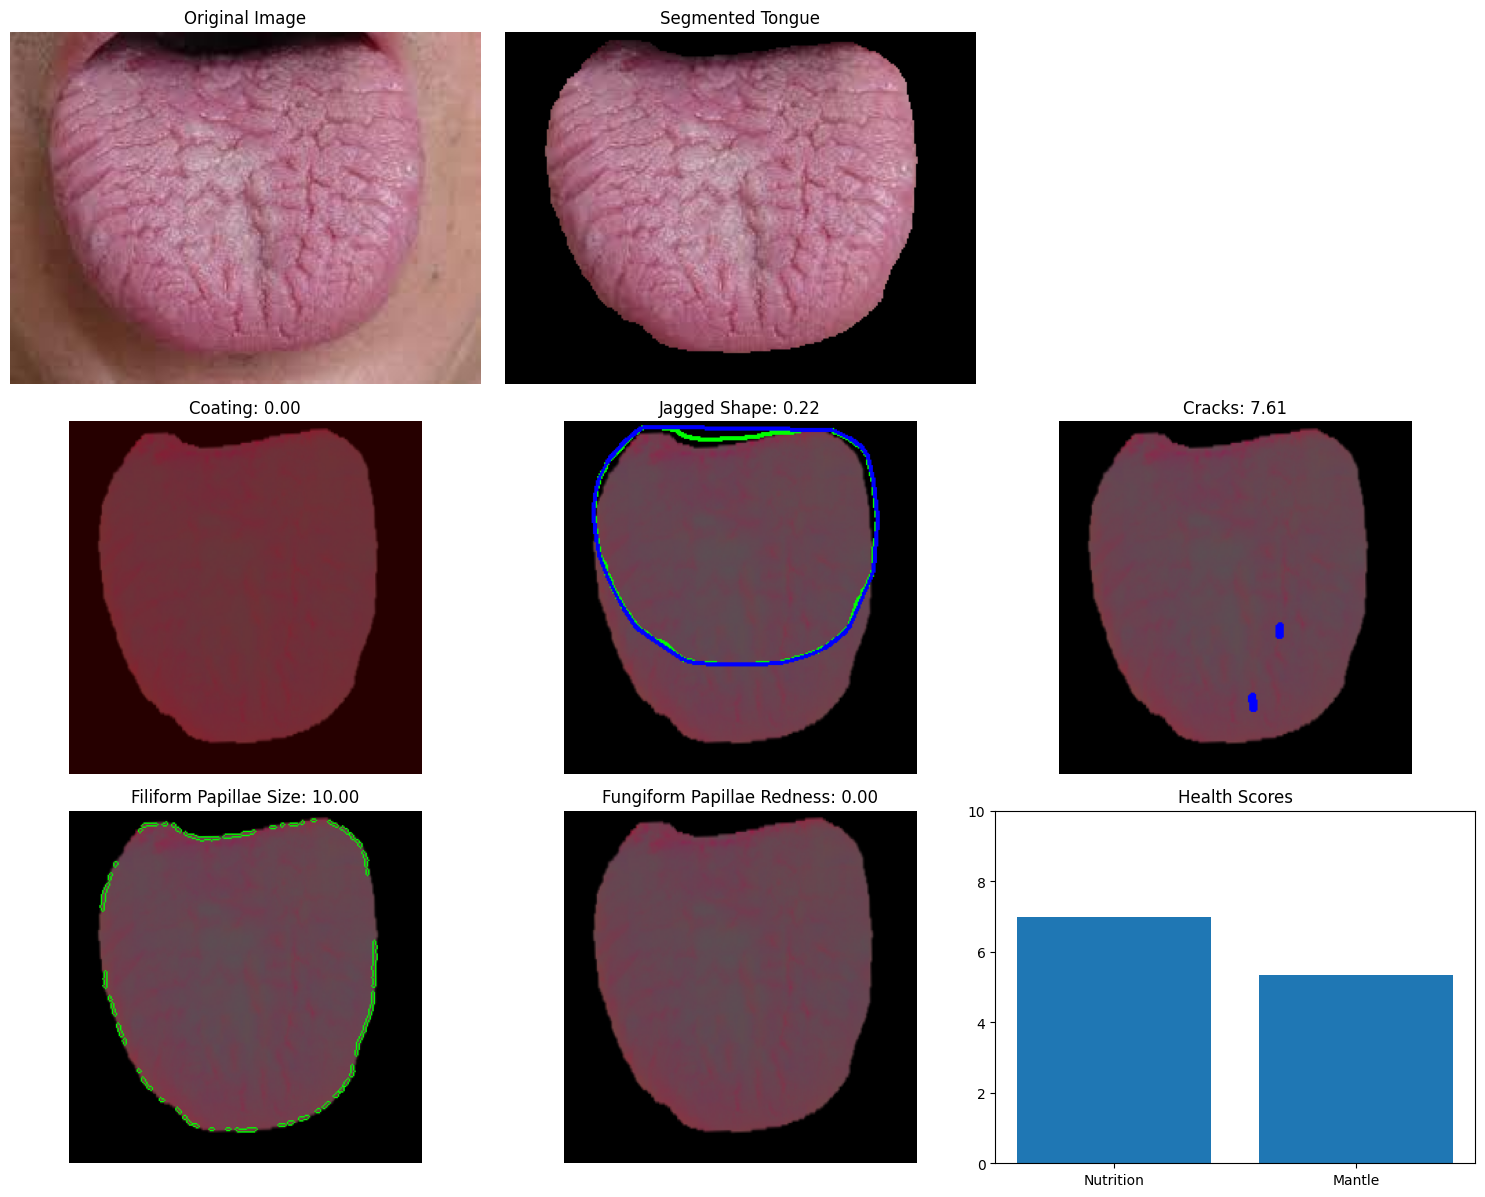

In [49]:

visualize_results(tongue_analysis_pipeline(tongue))

In [50]:
results = tongue_analysis_pipeline(tongue)
coating = extract_coating_score(tongue)
coating_score, coating_overlay = coating

jagged = extract_jagged_shape_score(tongue, mask)
jagged_score, jagged_overlay = jagged

crack = extract_cracks_score(tongue)
crack_score, crack_overlay = crack

papillae = extract_filiform_papillae_size_score(tongue)
papillae_score, papillae_overlay = papillae

redness = extract_fungiform_papillae_redness_score(tongue)
redness_score, redness_overlay = redness

mantle_score = compute_mantle_score(crack_score, jagged_score)
nutrition_score = compute_nutrition_score(coating_score, papillae_score, redness_score)

{'original_image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'segmented_tongue': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 

In [51]:
sentence = (
    f"My tongue has a coating score (each out of 10) of {coating_score:.2f}, "
    f"Predicted class: {class_names[predicted_class]}, "
    f"crack score of {crack_score:.2f}, "
    f"jaggedness score of {jagged_score:.2f}, "
    f"papillae size score of {papillae_score:.2f}, "
    f"redness score of {redness_score:.2f}. "
    f"Inference: Nutrition score is {nutrition_score:.2f}, mantle score is {mantle_score:.2f}."
    f"Give me a analysis of my tongue and what it means for my health in less than 30 words"
)
print(sentence)

My tongue has a coating score (each out of 10) of 0.00, Predicted class: fissured, crack score of 10.00, jaggedness score of 0.22, papillae size score of 6.33, redness score of 0.00. Inference: Nutrition score is 5.90, mantle score is 3.91.Give me a analysis of my tongue and what it means for my health in less than 30 words


In [52]:
conversation = [
    {"role": "user", "content": sentence}
]

reply = chat(model='thewindmom/llama3-med42-8b:latest', messages=conversation)
replied_message = (reply['message']['content'])

print(replied_message)

Your tongue has an extremely dry, fissured appearance with no coating, indicating poor hydration and potential nutritional deficiencies. The high crack score suggests increased risk for oral health issues.
